In [237]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from drone_model import DroneSimulator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set the trajectory


In [238]:
# Time
dt = 0.1
fs = 1 / dt
T = 8.0
tsim = np.arange(0, T + dt/2, step=dt)

In [239]:
# Time setup
dt = 0.1
T = 5.0
tsim = np.arange(0, T + dt/2, step=dt)

# Wind and Altitude
w = 4.1 * np.ones_like(tsim)                     # ambient wind speed
zeta = np.deg2rad(290) * np.ones_like(tsim)      # wind from WNW
z = 2.0 * np.ones_like(tsim)                     # constant altitude

# Speed: fast → drop during fake → sharp burst
g = 2.8 * np.ones_like(tsim)
i1 = int(2.0 / dt)
i2 = int(2.7 / dt)
i3 = int(3.3 / dt)
g[i1:i2] = 1.2                                    # deceleration during fake
g[i2:i3] = np.linspace(1.2, 3.2, i3 - i2)         # re-acceleration
g[i3:] = 3.0

# Path direction (psi_global)
psi_global = np.zeros_like(tsim)

# Phase 1: straight
psi_global[:i1] = np.deg2rad(0)

# Phase 2: initiate sharp left turn (fakeout)
psi_global[i1:i2] = np.linspace(np.deg2rad(0), np.deg2rad(135), i2 - i1)

# Phase 3: snap back in opposite direction
psi_global[i2:i3] = np.linspace(np.deg2rad(135), np.deg2rad(-60), i3 - i2)

# Phase 4: hold new direction (weird final angle)
psi_global[i3:] = np.deg2rad(-60)

# Heading: mostly follows path, but lags during fake/recovery
psi = np.copy(psi_global)
lag_offset = np.deg2rad(12)
psi[i1:i2] = psi_global[i1:i2] - lag_offset       # during fakeout
psi[i2:i3] = psi_global[i2:i3] - lag_offset       # during recovery

# Global frame x-y velocities
v_x_global = g * np.cos(psi_global)
v_y_global = g * np.sin(psi_global)

# Body-level frame x-y velocities (relative to heading)
v_x = v_x_global * np.cos(psi) + v_y_global * np.sin(psi)
v_y = -v_x_global * np.sin(psi) + v_y_global * np.cos(psi)


# Simulate trajectory


In [240]:
mpc_horizon = 10
mpc_control_penalty = 1e-2

In [241]:
# Create simulator
simulator = DroneSimulator(dt=dt, mpc_horizon=mpc_horizon, r_u=mpc_control_penalty)

# Change parameters
print(simulator.params.__dict__.keys())
simulator.params.Mm = 2.0  # example change the mass

dict_keys(['g', 'm', 'M', 'Mm', 'L', 'R', 'I_x', 'I_y', 'I_z', 'b', 'd', 'C'])


In [242]:
# Update the setpoints
simulator.update_setpoint(v_x=v_x, v_y=v_y, psi=psi, z=z, w=w, zeta=zeta)

# Run
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=True, return_full_output=True)
sim_data = pd.DataFrame(y_sim)
sim_data.insert(0, 'time', t_sim)
print('Done.')

Done.


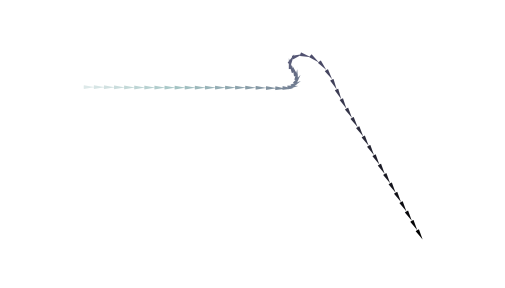

In [243]:
simulator.plot_trajectory(size_radius=0.3)

In [244]:
sim_data.to_csv("traj13.csv", index=False)

